# 📘 Retail Intelligence Agent System (RIA)
### Multi-Agent Retail Analytics Using Google ADK & Gemini  
#### **Track: Enterprise Agents**

The Retail Intelligence Agent System (RIA) is a multi-agent framework designed to automate retail business intelligence using Google’s **Agent Development Kit (ADK)** and **Gemini models**.

RIA integrates:

- **Insights Agent** → Historical KPI analytics  
- **Forecast Agent** → 3-month demand forecasting  
- **Recommendation Agent** → Strategy generation using insights + forecasts  
- **Coordinator Agent** → Routes user queries to the correct agent  

RIA demonstrates essential ADK concepts:

- ✔ Multi-Agent Systems  
- ✔ Custom FunctionTools  
- ✔ Sessions & Memory (InMemorySessionService)  
- ✔ Context Engineering  
- ✔ Observability with `run_debug()`  
- ✔ Scalable ADK architecture  

The system analyzes historical performance, predicts future sales, and generates business recommendations.

---


# 🗂 Table of Contents

1. Introduction  
2. Setup & Requirements  
3. Dataset Loading & Cleaning  
4. Exploratory Data Analysis (EDA)  
5. Problem Definition & Use Cases  
6. ADK Architecture Overview  
7. Insights Tool + Insights Agent  
8. Forecast Tool + Forecast Agent  
9. Recommendation Agent  
10. Coordinator (Router) Agent  
11. Observability & Context Engineering  
12. Results & Visualizations  
13. Limitations  
14. Future Work  
15. Conclusion  


## 🔧 Setup & Requirements

This cell installs the required libraries (Google ADK, Gemini, Statsmodels, Pandas, Matplotlib)  
and loads the Google API key from Kaggle Secrets.

This setup is required before creating any agent.


In [1]:
!pip install -q google-adk google-genai statsmodels pandas matplotlib

import os
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient

# Load API key from Kaggle Secrets
user_secrets = UserSecretsClient()
os.environ["GOOGLE_API_KEY"] = user_secrets.get_secret("GOOGLE_API_KEY")

print("Environment ready. ADK & Gemini successfully loaded.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires pyOpenSSL<=24.2.1,>=19.1.0, but you have pyopenssl 25.3.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.10.0 w

## 📥 Dataset Loading & Cleaning

The Superstore dataset is loaded from Kaggle.  
This cell:

- Loads the CSV  
- Converts date columns  
- Creates Month, Year, Quarter  
- Removes invalid values  
- Ensures the dataset is clean for analytics & forecasting  


In [2]:
DATA_PATH = "/kaggle/input/superstore-dataset-final/Sample - Superstore.csv"

df = pd.read_csv(DATA_PATH, encoding="latin-1")

# Convert to datetime
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

# Date features
df["Year"] = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.to_period("M").astype(str)
df["Quarter"] = df["Order Date"].dt.to_period("Q").astype(str)

# Cleaning
df = df[df["Sales"] >= 0]
df = df.dropna(subset=["Sales", "Profit", "Region", "Category"])

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Year,Month,Quarter
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,2016-11,2016Q4
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,2016-11,2016Q4
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,2016-06,2016Q2
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,2015-10,2015Q4
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,2015-10,2015Q4


## 📊 Dataset Summary

The Superstore dataset contains:

- ~10,000 customer orders  
- Sales, Profit, Quantity, Discount  
- Region, Category, Segment, State  
- 4 years of transaction history  

This dataset is suitable for multi-agent analytics, forecasting, and business recommendation tasks.


In [3]:
df.describe(include="all").T.head(20)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

# 🔍 Exploratory Data Analysis (EDA)

We explore:

- Monthly sales trends  
- Category profitability  
- Regional performance  

These insights help validate the dataset and motivate the need for predictive agents.


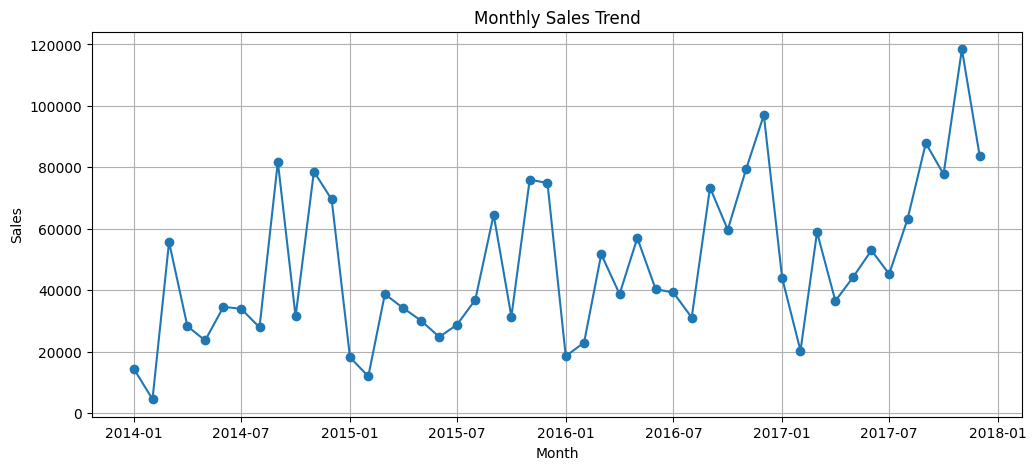

In [4]:
# Monthly sales trend
monthly_sales = (
    df.groupby(df["Order Date"].dt.to_period("M"))["Sales"].sum()
)
monthly_sales.index = monthly_sales.index.to_timestamp()

plt.figure(figsize=(12,5))
plt.plot(monthly_sales, marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


# 🎯 Problem Definition

Retail managers face several challenges:

- Slow manual analysis  
- Fragmented forecasting  
- No unified recommendation engine  

### **RIA solves these by enabling:**

1. Automated analytics using the Insights Agent  
2. AI-driven demand forecasting  
3. Strategy recommendations grounded in data  
4. Dynamic multi-agent collaboration  

___

# 🧱 ADK Architecture Overview

RIA uses four agents orchestrated via ADK:



<pre>
+----------------------------------------------+
|               Coordinator Agent              |
|     (routes user queries to sub-agents)      |
+---------------------+------------------------+
                      |
        +-------------+-------------+
        |                           |
+-------------------+     +--------------------+
|   InsightsAgent   |     |   ForecastAgent    |
|     (Analysis)    |     |    (Prediction)    |
+---------+---------+     +---------+----------+
          |                           |
          +-------------+-------------+
                        |
                        v
            +------------------------------+
            |     RecommendationAgent      |
            |       (Strategy Engine)      |
            +------------------------------+
</pre>


The next cells implement each agent step-by-step.

___

## 📦 Import ADK Components

This cell imports all ADK classes required to build:

- Agents  
- Runners  
- Session managers  
- FunctionTools  


In [5]:
from typing import Any, Dict
from google.adk.agents import LlmAgent
from google.adk.runners import Runner, InMemoryRunner
from google.adk.sessions import InMemorySessionService
from google.adk.models.google_llm import Gemini
from google.adk.tools.function_tool import FunctionTool

print("ADK components imported.")


ADK components imported.


## 🛠 Insights Tool

This tool aggregates sales, profit, quantity, and discount by:

- Region  
- Category  
- Segment  
- Month  
- Quarter  
- Year  

The InsightsAgent will call this tool for ANY analytical question.


In [8]:
def analyze_sales(group_by: str = "Category") -> Dict[str, Any]:
    """
    Compute grouped KPIs for the Superstore dataset.
    """
    grouped = (
        df.groupby(group_by)
          .agg(
              total_sales=("Sales", "sum"),
              total_profit=("Profit", "sum"),
              avg_profit=("Profit", "mean"),
              avg_discount=("Discount", "mean"),
              total_quantity=("Quantity", "sum")
          )
          .reset_index()
    )

    return {
        "grouped_by": group_by,
        "results": grouped.to_dict(orient="records")
    }

insights_tool = FunctionTool(analyze_sales)


## 🧠 Insights Agent

The InsightsAgent:

- Understands analytical queries  
- ALWAYS calls `insights_tool`  
- Returns clean summaries for business questions  

This cell defines the agent and creates a Runner for execution.


In [9]:
insights_agent = LlmAgent(
    name="InsightsAgent",
    description="Agent for grouped retail analytics.",
    model=Gemini(model="gemini-2.5-flash-lite"),
    tools=[insights_tool],
    instruction=(
        "You are a retail analytics agent. "
        "For any question involving KPIs, groups, trends, or comparisons, "
        "ALWAYS call insights_tool with the correct group_by field."
    )
)

insights_runner = InMemoryRunner(agent=insights_agent)


### ✅ Quick Test: InsightsAgent

Test the InsightsAgent on a simple analytics question to confirm that:

- It calls `insights_tool` correctly  
- It groups by the right field (Region)  
- It returns a clear business summary  


In [10]:
test_insights_query = (
    "Show me total sales, total profit, quantity and average discount grouped by Region. "
    "Use the appropriate group_by and give a short business summary."
)

response_insights = await insights_runner.run_debug(test_insights_query)



 ### Created new session: debug_session_id

User > Show me total sales, total profit, quantity and average discount grouped by Region. Use the appropriate group_by and give a short business summary.


InsightsAgent > The Central region exhibits the highest average discount (24%), potentially impacting its average profit per order, which is the lowest among all regions. Conversely, the West region shows strong performance with high total sales and quantity, coupled with a relatively low average discount and high average profit per order. The East and South regions show moderate performance in sales, quantity, and profit margins.


## 📈 Forecast Tool

The forecasting tool:

- Aggregates monthly sales  
- Fits Holt–Winters exponential smoothing  
- Predicts next **3 months** of regional sales  

Used by the ForecastAgent.


In [11]:
def forecast_sales(region: str = "West"):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing

    df_reg = df[df["Region"] == region]
    if df_reg.empty:
        return {"error": f"Region '{region}' not found."}

    monthly = (
        df_reg.groupby(df_reg["Order Date"].dt.to_period("M"))["Sales"]
              .sum()
              .astype(float)
    )
    monthly.index = monthly.index.to_timestamp()

    model = ExponentialSmoothing(monthly, trend="add", seasonal="add", seasonal_periods=12)
    fit = model.fit()
    fc = fit.forecast(3)

    return {
        "region": region,
        "forecast_next_3_months": {k.strftime("%Y-%m-%d"): float(v) for k, v in fc.items()}
    }

forecast_tool = FunctionTool(forecast_sales)
forecast_tool.name = "forecast_sales"


## 🤖 Forecast Agent

The ForecastAgent:

- Interprets forecasting queries  
- ALWAYS calls `forecast_sales`  
- Produces a forecast + short summary  

A runner is created for testing the agent.


In [12]:
forecast_agent = LlmAgent(
    name="ForecastAgent",
    description="Predicts 3-month future sales.",
    model=Gemini(model="gemini-2.5-flash-lite"),
    tools=[forecast_tool],
    instruction=(
        "For any forecasting question, ALWAYS call forecast_sales. "
        "Use the region mentioned in the user query."
    )
)

forecast_runner = Runner(
    agent=forecast_agent,
    app_name="RIA_App",
    session_service=InMemorySessionService()
)


### ✅ Quick Test: ForecastAgent

Test the ForecastAgent with a forecasting question to verify:

- It calls `forecast_sales`  
- Uses the correct region  
- Produces a 3-month forecast with an explanation  


In [13]:
test_forecast_query = (
    "Forecast total sales for the next 3 months in the West region. "
    "Use the forecasting tool and explain the trend briefly."
)

response_forecast = await forecast_runner.run_debug(test_forecast_query)



 ### Created new session: debug_session_id

User > Forecast total sales for the next 3 months in the West region. Use the forecasting tool and explain the trend briefly.


ForecastAgent > The forecast for the next three months in the West region shows a significant increase. Sales are projected to be approximately 14015.36 in January, dropping to 11720.80 in February, and then sharply rising to 27340.62 in March. This indicates a potential upward trend in sales towards the end of the quarter, despite a dip in February.


## 🧩 Recommendation Agent

This agent combines:

1. Insights (past performance)  
2. Forecasts (future demand)  

…and produces **3–5 actionable business recommendations**.

This is the core decision-support agent.


In [14]:
recommendation_agent = LlmAgent(
    name="RecommendationAgent",
    description="Generates strategic retail recommendations.",
    model=Gemini(model="gemini-2.5-flash-lite"),
    tools=[insights_tool, forecast_tool],
    instruction=(
        "You are a senior retail strategist.\n"
        "Step 1: ALWAYS call insights_tool for KPIs.\n"
        "Step 2: ALWAYS call forecast_sales for demand.\n"
        "Step 3: Combine both into actionable recommendations.\n"
        "Always cite numeric values."
    )
)

recommendation_runner = Runner(
    agent=recommendation_agent,
    app_name="RIA_App",
    session_service=InMemorySessionService()
)


### ✅ Quick Test: RecommendationAgent

This test checks that the RecommendationAgent:

1. Calls `insights_tool` for past KPIs  
2. Calls `forecast_sales` for future demand  
3. Combines both into concrete business recommendations  


In [15]:
test_reco_query = (
    "For the West region and Furniture category, analyse current sales, profit, "
    "quantity and discount, forecast total sales for the next 3 months, and "
    "suggest 3 concrete actions to improve profit. "
)

response_reco = await recommendation_runner.run_debug(test_reco_query)



 ### Created new session: debug_session_id

User > For the West region and Furniture category, analyse current sales, profit, quantity and discount, forecast total sales for the next 3 months, and suggest 3 concrete actions to improve profit. 


RecommendationAgent > The West region generated $741,999.80 in sales from Furniture in the last period. The average discount for this category is 17.39%, with an average profit of $8.70 per unit.

The forecasted sales for the West region for the next three months are:
*   **January 2018:** $14,015.36
*   **February 2018:** $11,720.80
*   **March 2018:** $27,340.62

**Recommendations to improve profit in the Furniture category for the West region:**

1.  **Reduce Discounts:** The average discount of 17.39% is significantly impacting profitability. Consider reducing the discount on furniture items, especially on lower-profit items, to increase the average profit margin.
2.  **Optimize Inventory:** Analyze sales data to identify slow-moving furniture items and consider reducing inventory for these products to free up capital and reduce storage costs. Conversely, ensure sufficient stock for high-demand, high-profit furniture items.
3.  **Promotional Strategies:** Instead of broad discounts

## 🧭 Coordinator (Router) Agent

This layer automatically selects the correct agent based on the user's query.

- Forecast questions → ForecastAgent  
- Strategy questions → RecommendationAgent  
- All other analytics → InsightsAgent  


In [16]:
def route_query(query: str) -> str:
    q = query.lower()

    if any(k in q for k in ["forecast", "predict", "future", "projection"]):
        return "forecast"

    if any(k in q for k in ["recommend", "strategy", "improve", "action"]):
        return "recommend"

    return "insights"


## ▶ Unified RIA Execution Function

This function executes the correct agent through the router  
and prints model traces using `run_debug()`.


In [17]:
async def run_ria(query: str):
    route = route_query(query)

    if route == "forecast":
        return await forecast_runner.run_debug(query)
    elif route == "recommend":
        return await recommendation_runner.run_debug(query)
    else:
        return await insights_runner.run_debug(query)


### ▶ End-to-End Tests: Retail Intelligence Agent System (RIA)

Now we query the unified RIA entrypoint `run_ria(...)`.  
The router decides which agent to use automatically based on the question.


In [18]:
# 1) Pure analytics question → should route to InsightsAgent
q1 = "Compare total sales and profit by Region and highlight the best and worst performing regions."
await run_ria(q1)

# 2) Forecasting question → should route to ForecastAgent
q2 = "Forecast sales for the next 3 months in the Central region and explain if it is growing or declining."
await run_ria(q2)

# 3) Strategy question → should route to RecommendationAgent
q3 = (
    "Given the current performance in the West region, suggest 3 actionable strategies "
    "to improve overall profit in the next quarter."
)
await run_ria(q3)



 ### Continue session: debug_session_id

User > Compare total sales and profit by Region and highlight the best and worst performing regions.


InsightsAgent > Here's a comparison of total sales and profit by region:

**Total Sales:**
*   West: $725,457.82
*   East: $678,781.24
*   Central: $501,239.89
*   South: $391,721.91

**Total Profit:**
*   West: $108,418.45
*   East: $91,522.78
*   Central: $39,706.36
*   South: $46,749.43

**Performance Highlights:**

*   **Best Performing Region:** The **West** region is the best performing in terms of both total sales and total profit.
*   **Worst Performing Region:** The **South** region has the lowest total sales, and the **Central** region has the lowest total profit.

 ### Continue session: debug_session_id

User > Forecast sales for the next 3 months in the Central region and explain if it is growing or declining.


ForecastAgent > The sales forecast for the Central region indicates a volatile trend over the next three months. Sales are predicted to be around 11274.59 in January, followed by a substantial drop to 3549.17 in February. However, sales are expected to rebound significantly in March, reaching approximately 13277.83. While there's a sharp decline in February, the strong recovery in March suggests an overall potential for growth towards the end of the period.

 ### Continue session: debug_session_id

User > Given the current performance in the West region, suggest 3 actionable strategies to improve overall profit in the next quarter.


RecommendationAgent > In the West region, the Technology category leads in total sales ($836,154.03) and average profit per unit ($78.75), while Furniture has the highest average discount (17.39%) and the lowest average profit per unit ($8.70). Office Supplies falls in between. The overall sales forecast for the West region for the next three months is approximately $53,076.79.

Here are 3 actionable strategies to improve overall profit in the West region for the next quarter:

1.  **Leverage High-Profit Categories:** Increase focus on the Technology category. This could involve targeted marketing campaigns, optimizing product placement, and ensuring sufficient inventory of high-margin technology products. Given its high average profit, boosting sales volume in this category will have a significant impact on overall profitability.

2.  **Address Furniture Profitability:** Implement strategies to improve the profit margin for the Furniture category. This could include:
    *   Negotiati

[Event(model_version='gemini-2.5-flash-lite', content=Content(
   parts=[
     Part(
       function_call=FunctionCall(
         args={
           'group_by': 'Category'
         },
         id='adk-710f2de8-081f-4913-8cb5-0337190db7b7',
         name='analyze_sales'
       )
     ),
     Part(
       function_call=FunctionCall(
         args={
           'region': 'West'
         },
         id='adk-e40c2ddf-5d51-4529-9eb0-565488679aaf',
         name='forecast_sales'
       )
     ),
   ],
   role='model'
 ), grounding_metadata=None, partial=None, turn_complete=None, finish_reason=<FinishReason.STOP: 'STOP'>, error_code=None, error_message=None, interrupted=None, custom_metadata=None, usage_metadata=GenerateContentResponseUsageMetadata(
   candidates_token_count=32,
   prompt_token_count=1003,
   prompt_tokens_details=[
     ModalityTokenCount(
       modality=<MediaModality.TEXT: 'TEXT'>,
       token_count=1003
     ),
   ],
   total_token_count=1035
 ), live_session_resumption_upd

### 💬Interactive RIA Chat
To make the system easier to use, I expose a single entry point:
`chat_with_ria()`.  
A small router function inspects the user’s query and decides whether to call:

- the **Insights Agent** (analytics),
- the **Forecast Agent** (time-series forecasting), or
- the **Recommendation Agent** (strategy and actions).

This mirrors the Coordinator/Orchestrator pattern from the course.


Type 'exit' to stop.


In [19]:
async def chat_with_ria():
    print("💬 Retail Intelligence Agent System (RIA)")
    print("Type 'exit' to stop.\n")
    while True:
        user_message = input("You: ")
        if user_message.lower() in ["exit", "quit"]:
            print("Goodbye!")
            break
        await run_ria(user_message)

# comment if you don't want to use:
await chat_with_ria()


💬 Retail Intelligence Agent System (RIA)
Type 'exit' to stop.



You:  analyze the sales for segment



 ### Continue session: debug_session_id

User > analyze the sales for segment


InsightsAgent > The analysis of sales by segment reveals the following:

*   **Consumer Segment:** This segment has the highest total sales ($1,161,401.35) and the largest quantity sold (19,521 units). However, it has the lowest average profit per order ($25.84).
*   **Corporate Segment:** This segment shows solid performance with total sales of $706,146.37 and a higher average profit per order ($30.46) compared to the Consumer segment.
*   **Home Office Segment:** While having the lowest total sales ($429,653.15) and quantity sold (6,744 units), this segment boasts the highest average profit per order ($33.82).

**Summary:** The Consumer segment drives the most revenue, but the Home Office segment is the most profitable on a per-order basis. The Corporate segment falls in between these two.


You:  exit


Goodbye!


# 🛰 Observability & Context Engineering

`run_debug()` shows:

- Tool call arguments  
- Intermediate reasoning  
- Generated traces  
- Final model response  

This fulfills **Day 4 – Agent Quality** requirements.


# 📊 Results & Visualizations


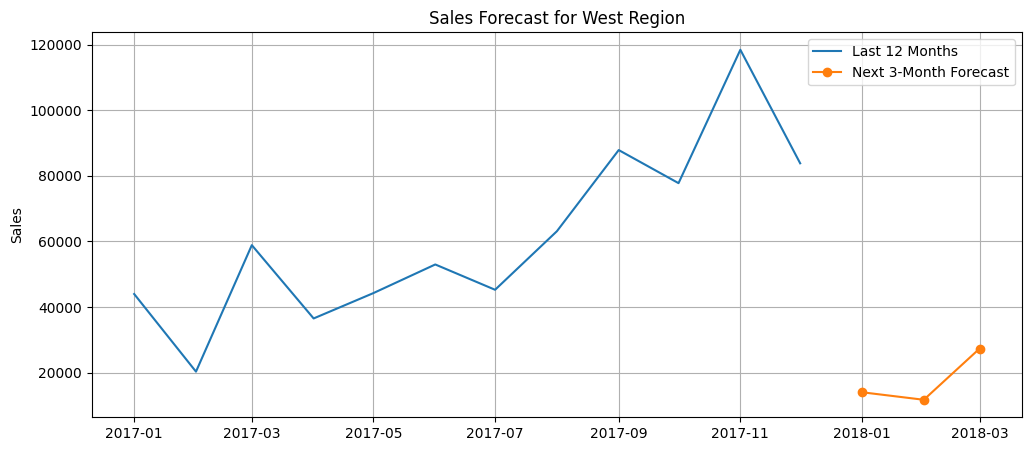

In [20]:
region = "West"

forecast_data = forecast_sales(region)["forecast_next_3_months"]
forecast_series = pd.Series(forecast_data)
forecast_series.index = pd.to_datetime(forecast_series.index)

plt.figure(figsize=(12,5))
plt.plot(monthly_sales[-12:], label="Last 12 Months")
plt.plot(forecast_series, marker="o", label="Next 3-Month Forecast")
plt.title(f"Sales Forecast for {region} Region")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


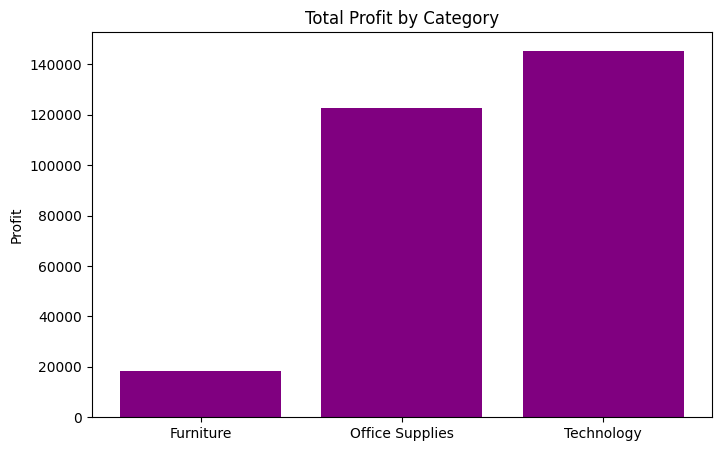

In [21]:
category_profit = df.groupby("Category")["Profit"].sum().sort_values()

plt.figure(figsize=(8,5))
plt.bar(category_profit.index, category_profit.values, color="purple")
plt.title("Total Profit by Category")
plt.ylabel("Profit")
plt.show()


# ⚠ Limitations

- Holt–Winters cannot model shocks/holidays  
- Category-level forecasting not implemented  
- Keyword-based router instead of semantic router  
- No database integration or real-time streaming  


## 🔮 Future Work

To further enhance the Retail Intelligence Agent System (RIA), the following improvements are recommended:

1. **More Forecasting Models**  
   Add ARIMA, Prophet, LightGBM, or hybrid deep-learning models for improved accuracy.

2. **Customer Segmentation Module**  
   Implement RFM scoring, clustering, or churn prediction.

3. **Real-Time Pipeline Integration**  
   Connect the system with cloud databases (BigQuery, Firestore, PostgreSQL).

4. **Interactive RIA Dashboard**  
   Build a Streamlit/Gradio dashboard with charts and agent chat interface.

5. **Automated Anomaly Detection**  
   Identify sudden drops in sales, discounts, margin erosion, or unusual inventory patterns.

6. **Promotion Optimization Engine**  
   Suggest promotional strategies using uplift modelling or price elasticity analysis.

7. **More Advanced Multi-Agent Collaboration**  
   Introduce new agents such as Pricing Agent, Inventory Agent, or Customer Experience Agent.


## 🧾 Conclusion

The Retail Intelligence Agent System (RIA) integrates LLM-powered reasoning,
analytical tooling, and time-series forecasting to support retail
decision-making.

Using Google ADK, the system coordinates:

- **Insights Tool** – performs grouped sales, profit, discount, and quantity analysis.  
- **Forecast Tool** – predicts future sales using Holt–Winters Exponential Smoothing.  
- **Recommendation Agent** – combines insights + forecasts to generate actionable strategy.  
- **Session & State Support** – `InMemorySessionService` enables multi-turn conversations,
  where follow-up questions can refer back to previous context.

The agents:

- Interpret natural-language questions.  
- Automatically invoke the relevant `FunctionTool`s.  
- Process analytics and forecasting requests.  
- Produce clear, human-friendly business recommendations.

This demonstrates how LLM-based agents can bridge the gap between raw retail data and
strategic decision-making, following the architectures and patterns from the
5-Day AI Agents Intensive course.
